In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

cuda = torch.device('cuda')

In [2]:
train_dir = "../dev-data/train.csv"
X_train = pd.read_csv(train_dir).drop('label', axis = 1)
y_train = pd.read_csv(train_dir)['label']


In [3]:
def pixel_row_to_array(row):
    return row.to_numpy().reshape(28, 28)

class MNISTDataset(Dataset):
    
    #takes in df of images and labels
    def __init__(self, df, labels = None, train = None, train_test_ratio = 0.1):
        
        self.df = df
        self.train = train
        self.labels = labels
        
        num_samples = len(self.df.index)
        split_index = int(num_samples * train_test_ratio)
        
        
        if self.train == True:
            self.df = self.df.iloc[split_index:]
            self.labels = self.labels.iloc[split_index:]
            
        elif self.train == False:
            self.df = self.df.iloc[:split_index]
            self.labels = self.labels.iloc[:split_index]
        
    def __len__(self):
        return len(self.df.index)
        
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = pixel_row_to_array(row)
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
        
        label = 0
        
        if self.labels is not None:
            label = self.labels.iloc[index]
        
        return image, label


In [4]:
train_dataset = MNISTDataset(X_train, labels = y_train, train = True)
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size = 4)

valid_dataset = MNISTDataset(X_train, labels = y_train, train = False)
valid_dataloader = DataLoader(valid_dataset, shuffle = True, batch_size = 4)

In [5]:
class LeNet5(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride = 1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 3, stride = 1),
            nn.Tanh()
        )
        
        self.linearlayers = nn.Sequential(
            nn.Linear(in_features = 1080, out_features = 84),
            nn.Tanh(),
            nn.Linear(in_features = 84, out_features = num_classes)
        )
        
    def forward(self, x):
        x = self.convlayers(x)
        x = torch.flatten(x, 1)
        logits = self.linearlayers(x)
        probs = F.softmax(logits, dim = 1)
        return logits, probs

In [6]:
def train(model, train_loader, optimizer, criterion, device):
    
    running_loss = 0.0
    model.train()
    
    for X, y in train_loader:
        
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
        
        outputs, _ = model(X.float())
        loss = criterion(outputs, y)
        loss_item = loss.item()
        
        running_loss += loss_item * X.shape[0]
        
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss
        
        
def validate(model, valid_loader, criterion, device):
    
    running_loss = 0.0
    model.eval()
    
    for X, y in valid_loader:
        
        X = X.to(device)
        y = y.to(device)
        
        outputs, _ = model(X.float())
        loss = criterion(outputs, y)
        running_loss += loss.item() * X.shape[0]
        
        
    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [7]:
def training_loop(model, optimizer, criterion, num_epochs, device, train_loader, valid_loader, print_every = 1):
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        
        
        model, optimizer, train_loss = train(model,
                                            train_loader,
                                            optimizer, 
                                            criterion,
                                            device)
        
        model, valid_loss = validate(model,
                                valid_loader,
                                criterion,
                                device)
        
        print("completed epoch " + str(epoch))
    
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    return model, optimizer, train_losses, valid_losses
    

In [8]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
model = LeNet5().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, train_losses, valid_losses = training_loop(model,
                                                             optimizer,
                                                             criterion,
                                                             NUM_EPOCHS,
                                                             DEVICE,
                                                             train_dataloader,
                                                             valid_dataloader)

completed epoch 0
completed epoch 1
completed epoch 2
completed epoch 3
completed epoch 4
completed epoch 5
completed epoch 6
completed epoch 7
completed epoch 8
completed epoch 9


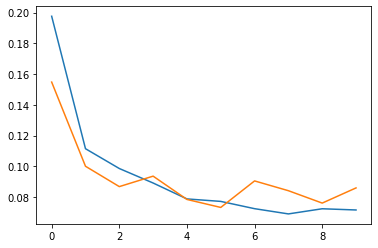

In [9]:
plt.plot(train_losses, label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.show()

In [10]:
def get_accuracy(model, test_loader, device):
    
    correct_preds = 0 
    total_preds = 0
    
    with torch.no_grad():
        model.eval()
        
        for X, y_true in test_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X.float())
            _, labels = torch.max(y_prob, 1)

            total_preds += y_true.size(0)
            correct_preds += (labels == y_true).sum()

    return correct_preds.float() / total_preds

In [11]:
print(str("accuracy: " + str(get_accuracy(model, valid_dataloader, DEVICE).item() * 100)[:2] + "%"))

accuracy: 97%


In [12]:
def complete_preds(model, test_dataloader, device):
    
    df = pd.DataFrame(columns = ["ImageId", "Label"])
    
    ImageId = 1
    
    with torch.no_grad():
        model.eval()
        for X, _ in test_dataloader:
            
            X = X.to(device)
            _, probs = model(X.float())
            _, predicted_labels = torch.max(probs, 1)
            
            for label in predicted_labels:
                label = label.item()
                
                #append prediction and imageid to dataframe
                df = df.append({"ImageId" : ImageId, "Label" : label}, ignore_index = True)
                
                ImageId += 1
                
    return df

In [13]:
test_csv = pd.read_csv('../dev-data/test.csv')
test_dataset = MNISTDataset(test_csv, labels = None)
test_dataloader = DataLoader(test_dataset, batch_size = 4)

In [14]:
predictions = complete_preds(model, test_dataloader, DEVICE)
predictions.to_csv("../dev-data/predictions.csv", index = False)